# Paths between BP solutions

Given an instance

- construct a basis $\mathcal{B}=\{v_1,...,v_k\}$ of seaweeds
- find 2 distinct solutions $x_1,x_2$ with BP
- build $x=x_1\oplus x_2$
- find a path of "small" jumps from $0$ to $x$: $x=\alpha^i v_i$
- plot the distortion of of the codeword along the path from $x_1$ to $x_2$

In [11]:
include("../code/bp_full.jl")
include("../code/seaweed.jl")
using OffsetArrays

Build graph and remove some factors

In [13]:
m = factorial(5)*11
R = 0.8/3
f3 = 1 - 3R
n = round(Int, 3m/(2+f3))
@show n
Λ = [0,1-f3,f3]
K = [0,0,1]
nedges = 3m
b = round(Int, 3*sqrt(n))

n = 1800


127

In [14]:
Ht = ldpc_matrix(n, m, nedges, Λ, K)
# remove b factors
Ht = Ht[:,1:end-b]
dropzeros!(Ht)
H = sparse(permutedims(copy(Ht)));

### Build a first basis with gaussian elimination

This will in general not be sparse. We just use it to compute the size of the space of solutions, i.e. the number of needed independent seaweeds.

We build two different basis => two sets of independent variables => use them to find 2 different BP solutions

In [15]:
BB1, indep1 = findbasis(H)
@assert iszero(H*BB1.%2)
dim1 = length(indep1)

607

In [16]:
BB2, indep2 = findbasis(H)
@assert iszero(H*BB2.%2)
dim2 = length(indep2)

607

## Build the basis B using seaweeds

In [17]:
fg = FactorGraphGF2(Int.(H))
nsw = 5*fg.n
B, niters = seaweed_basis(nsw, fg, dim1)
println("Basis found after trying ", niters, " seaweeds")

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/crotti/.julia/packages/ProgressMeter/0ub8y/src/ProgressMeter.jl:474
Progress:  20%|████████▏                                |  ETA: 0:05:56
  iter:  1796
  dim:   607

Basis found after trying 1798 seaweeds


### Find 2 BP solutions

In [36]:
# external field strength
HH = 1.3
s = rand((-1,1), n)
efield = [(exp(ss*HH),exp(-ss*HH)) for ss in s]
bp = BPFull(H)
bp.efield .= efield;

In [37]:
bp1 = deepcopy(bp)
bp2 = deepcopy(bp);

In [38]:
nunsat1,_,dist1 = decimate!(bp1, efield, indep1, s;  tol=1e-4, fair_decimation=true)

Trial 1 of 1: 0 unsat. Dist = 0.222


(0, 0.5555555555555556, 0.2222222222222222)

In [39]:
nunsat2,_,dist2 = decimate!(bp2, efield, indep2, s;  tol=1e-4, fair_decimation=true)

Trial 1 of 1: 0 unsat. Dist = 0.224


(0, 0.5511111111111111, 0.22444444444444445)

In [40]:
x1 = argmax.(bp1.belief) .== 2
@assert sum(H*x1 .% 2) == 0
x2 = argmax.(bp2.belief) .== 2
@assert sum(H*x2 .% 2) == 0

Compute $x=x_1\oplus x_2$ and check that they are indeed two different codewords

In [41]:
x = xor.(x1,x2)
@assert sum(H*x .% 2) == 0
sum(x)

332

Compression performance is not great because we removed quite a lot of checks

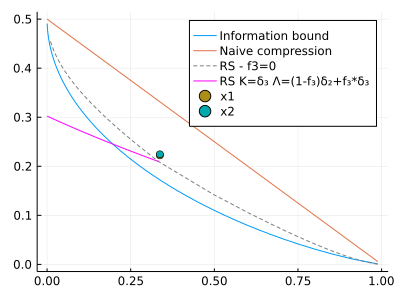

In [42]:
Rtrue = dim1/n
pl = plot_rdb()
scatter!(pl, [Rtrue], [dist1], label="x1")
scatter!(pl, [Rtrue], [dist2], label="x2")
plot(pl, size=(400,300))

### Find a path of small jumps
To find the expansion coefficients $\alpha$ of $x$ on the basis, solve $B\alpha=x$:
- Build $A=[B |x]$
- Reduce it with row operations to 
                                   |   | |
                                   | I |a|
                                   |___|_|
                                   | 0 |0|

In [112]:
A = ([B x])
A,dep = gfrrefGF2!(A)
dropzeros!(A)
alpha = A[dep,end]
@assert B*alpha.%2 == x
sum(alpha)

200

Build path from $0$ to $x$ by accumulating each small jump via a $\oplus$ operation

In [113]:
function build_path(B, alpha, x)
    n = length(x)
    nz_alpha = findall(alpha)
    P = falses(n,length(nz_alpha)+1)
    for (i,a) in enumerate(nz_alpha)
        P[:,i+1] .= xor.(P[:,i], B[:,a])
    end
    @assert P[:,end] == x
    P
end

build_path (generic function with 1 method)

In [114]:
# build path picking at each step the basis vector that gives the
#  lowest distortion wrt the source `y`
function build_lowdist_path(B, alpha, x, y)
    n = length(x)
    nz_alpha = findall(alpha)
    P = falses(n,length(nz_alpha)+1)
    for i in 1:length(nz_alpha)
        # pick next 
        j = argmin([sum(B[:,a].!=y) for a in nz_alpha])
        a = nz_alpha[j]
        P[:,i+1] .= xor.(P[:,i], B[:,a])
        deleteat!(nz_alpha, j)
    end
    @assert P[:,end] == x
    P
end

build_lowdist_path (generic function with 1 method)

In [115]:
# P = build_path(B, alpha, x)
P = build_lowdist_path(B, alpha, x, s.==-1)
weight_jumps = sum(P, dims=1)

1×201 Matrix{Int64}:
 0  96  94  117  148  157  169  175  …  423  383  367  362  343  343  332

### Observe the distortion

To go from path $P=(0,\dots,x)$ to $P_1=(x_1,\dots,x_2)$, just do $P_1=P\oplus x_1$

In [116]:
P1 = reduce(hcat, [xor.(P[:,i],x1) for i in 1:size(P,2)])
@assert P1[:,end]==x2

In [117]:
d = [distortion(s, 1 .- 2p) for p in eachcol(P1)]
boltz_weight = exp.(-d*HH);

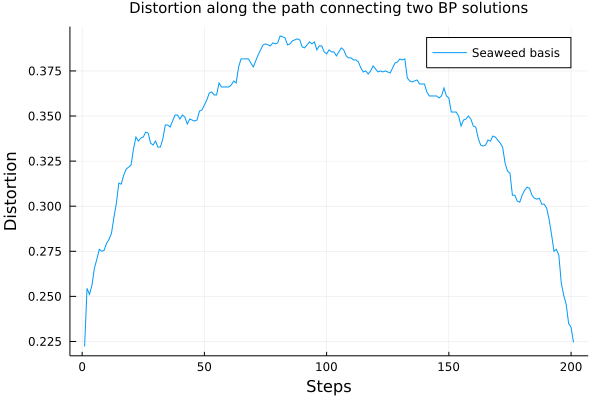

In [118]:
p1 = plot(d, label="Seaweed basis"); xlabel!("Steps"); ylabel!("Distortion")
title!("Distortion along the path connecting two BP solutions")
plot!(titlefontsize=10)

## Build path using the leaf-removal basis

In [119]:
A = ([BB1 x])
A,dep = gfrrefGF2!(A)
dropzeros!(A)
alpha = A[dep,end]
@assert BB1*alpha.%2 == x
sum(alpha)

126

In [120]:
# P = build_path(B, alpha, x)
PP = build_lowdist_path(BB1, alpha, x, s.==-1)
weight_jumps = sum(PP, dims=1)

1×127 Matrix{Int64}:
 0  18  11  24  41  53  63  79  81  93  …  355  347  351  349  346  341  332

### Observe the distortion

To go from path $P=(0,\dots,x)$ to $P_1=(x_1,\dots,x_2)$, just do $P_1=P\oplus x_1$

In [121]:
P2 = reduce(hcat, [xor.(PP[:,i],x1) for i in 1:size(PP,2)])
@assert P2[:,end]==x2

In [122]:
d2 = [distortion(s, 1 .- 2p) for p in eachcol(P2)]
boltz_weight = exp.(-d*HH);

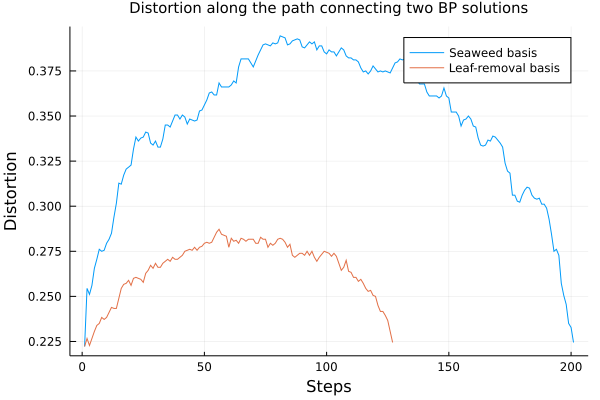

In [123]:
plot!(p1,d2, label="Leaf-removal basis"); xlabel!("Steps"); ylabel!("Distortion")
title!("Distortion along the path connecting two BP solutions")
plot!(titlefontsize=10)

In [75]:
maximum(d)

0.2872222222222222

In [106]:
sort(proportionmap(vec(sum(fg.H, dims=1))))

OrderedCollections.OrderedDict{Int64, Float64} with 4 entries:
  0 => 0.00888889
  1 => 0.145556
  2 => 0.694444
  3 => 0.151111